# Notebook Version

- Version 1 (11/30/2024)
   * EDA
   * Baseline modeling 1.0
 

# Loading Libraries

In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

CPU times: user 2.71 s, sys: 539 ms, total: 3.25 s
Wall time: 5.43 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e12/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e12/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (1200000, 20)
The dimension of the test dataset is: (800000, 19)
CPU times: user 4.9 s, sys: 1.18 s, total: 6.08 s
Wall time: 8.23 s


In [3]:
train.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
test.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
id,,,,,,,,,,,,,,,,,,,
1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Train ---

Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64


--- Test ---

Age                      1.561125
Gender                   0.000000
Annual Income            3.732500
Marital Status           1.542000
Number of Dependents     9.141250
Education Level          0.000000
Occupation              29.890625
Health Score             6.181125
Lo

From the above, we see that `Occupation` and `Previous Claims` are the features with the highest percentage of missing values. Next, we check for potential duplicates.

In [6]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the Premium Amount column, there are {sum(train.drop(columns=['Premium Amount']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the Premium Amount column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [7]:
temp_train = train.drop(columns=['Premium Amount'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the distribution of `Premium Amount`.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


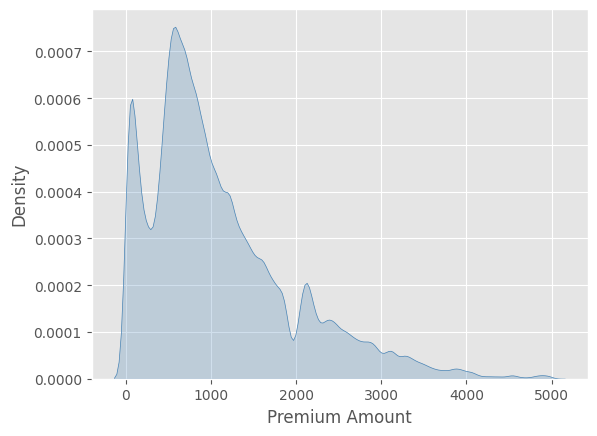

In [8]:
sns.kdeplot(data=train, x='Premium Amount', color='steelblue', fill=True);

From the above, we see that the distribution is tri-modal and right-skewed. Next, we explore potential relationships between the input features and `Premium Amount`.

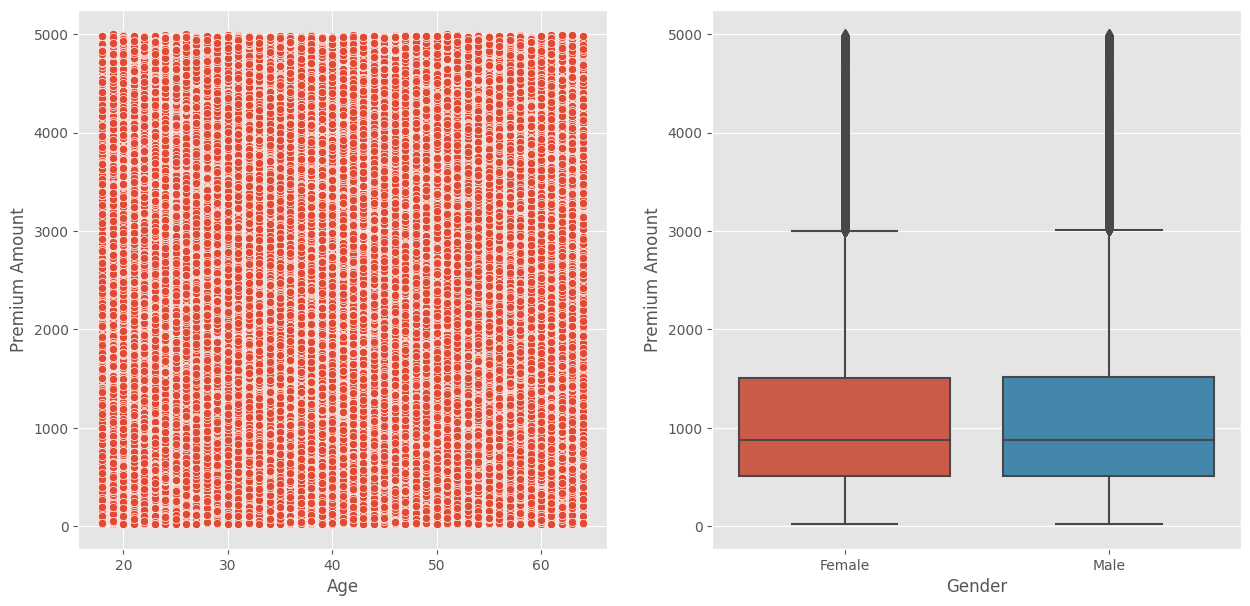

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plt_1 = sns.scatterplot(data=train, x='Age', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Gender', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

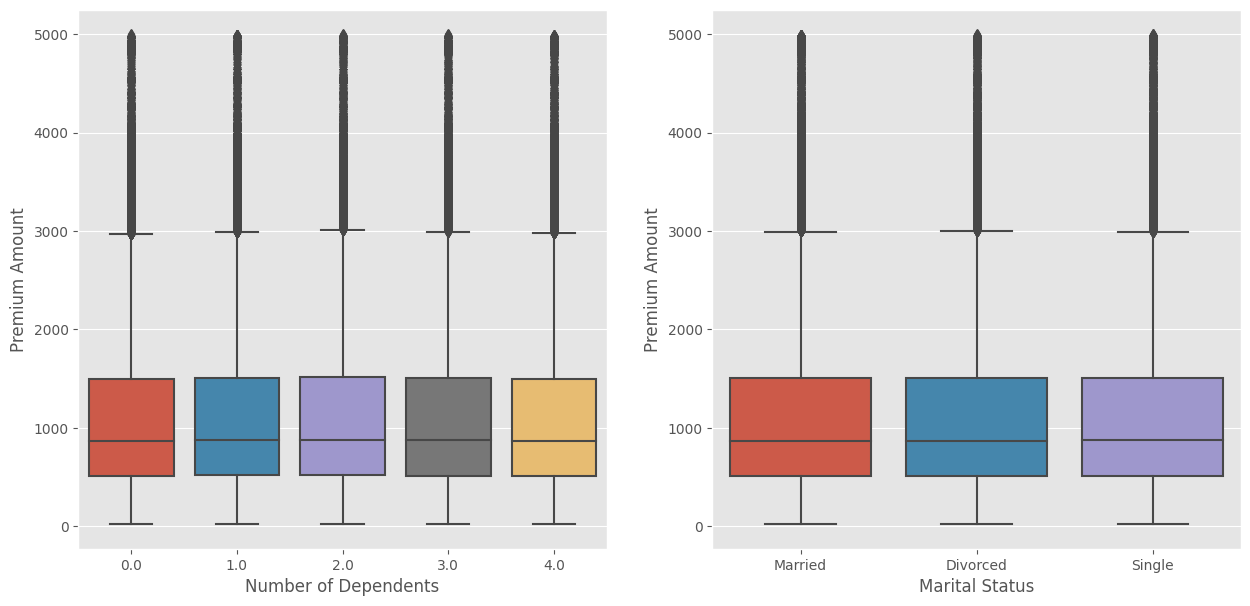

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plt_1 = sns.boxplot(data=train, x='Number of Dependents', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Marital Status', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

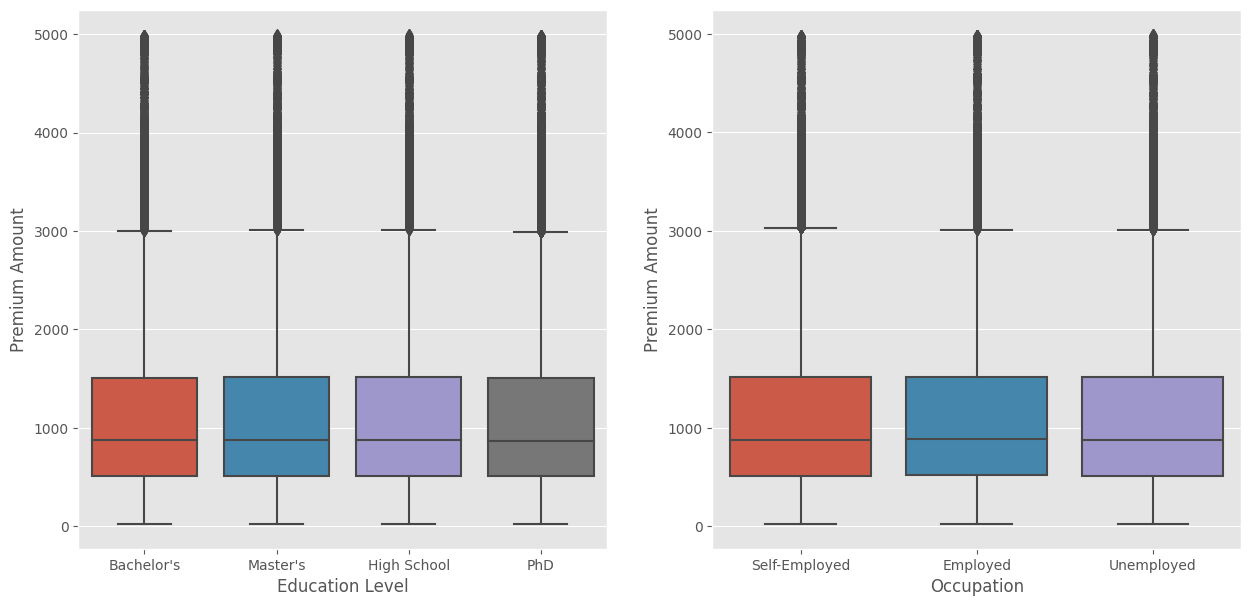

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plt_1 = sns.boxplot(data=train, x='Education Level', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Occupation', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

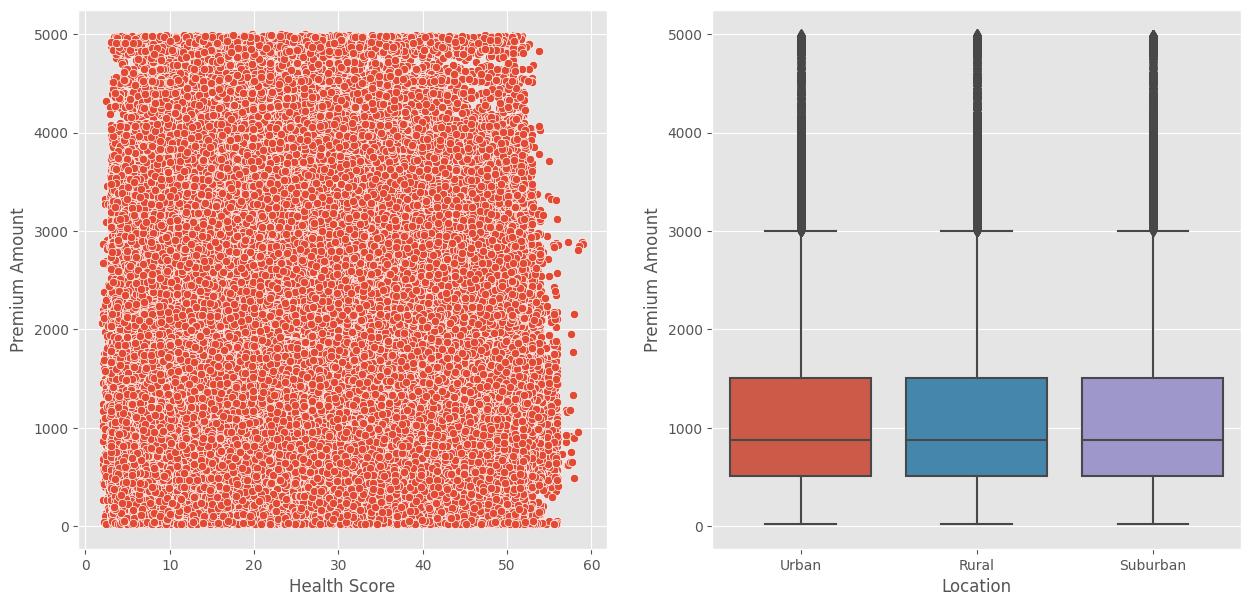

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plt_1 = sns.scatterplot(data=train, x='Health Score', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Location', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

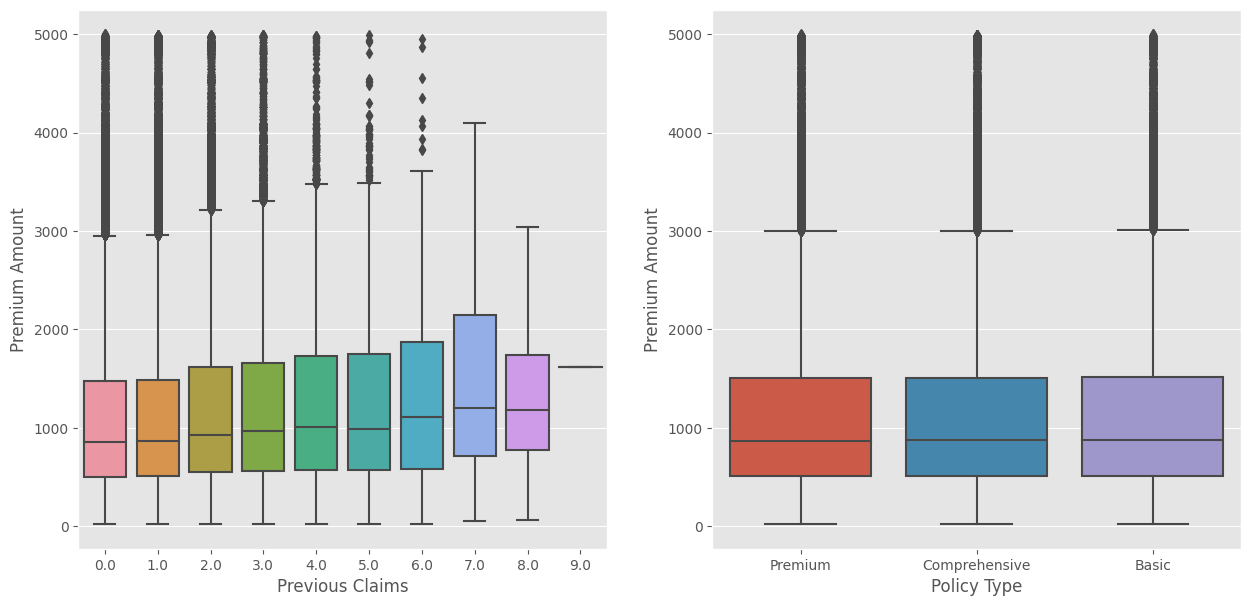

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plt_1 = sns.boxplot(data=train, x='Previous Claims', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Policy Type', y='Premium Amount', ax=ax[1]);

From the left panel, it seems that there is a slightly upward trend as `Previous Claims` increases. Also note that there is one observation with `Previous Claims=9`.

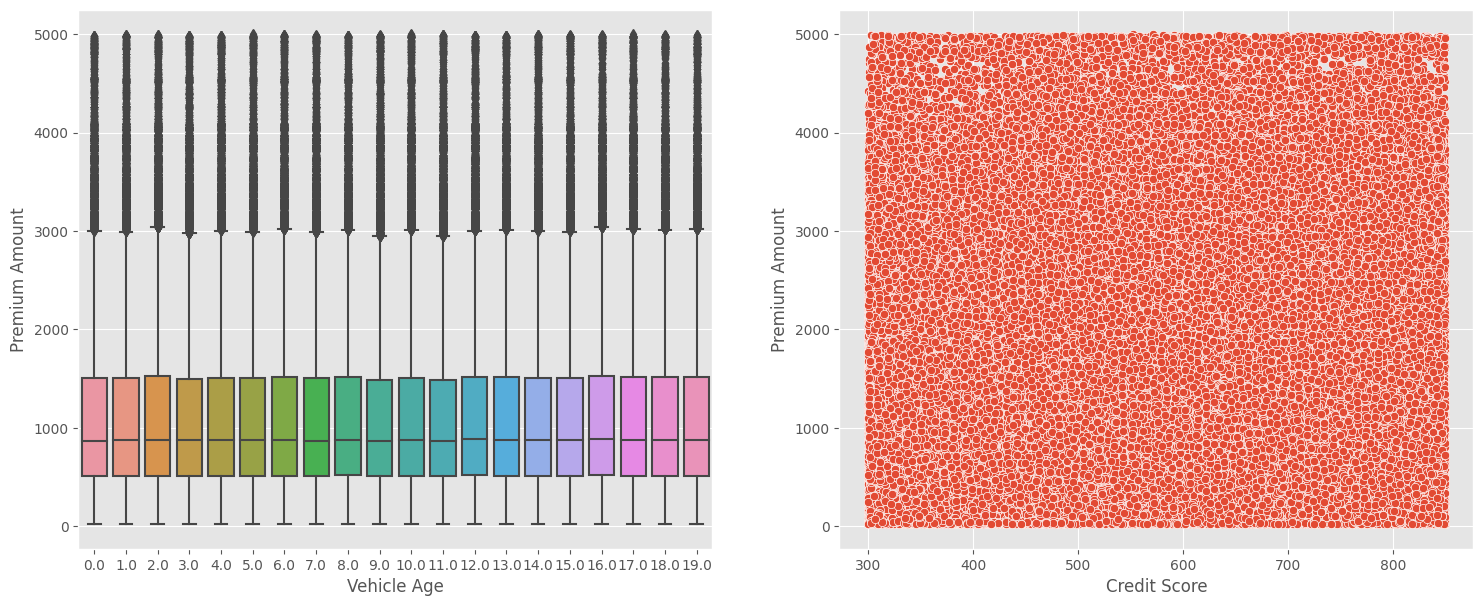

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

plt_1 = sns.boxplot(data=train, x='Vehicle Age', y='Premium Amount', ax=ax[0])
plt_2 = sns.scatterplot(data=train, x='Credit Score', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

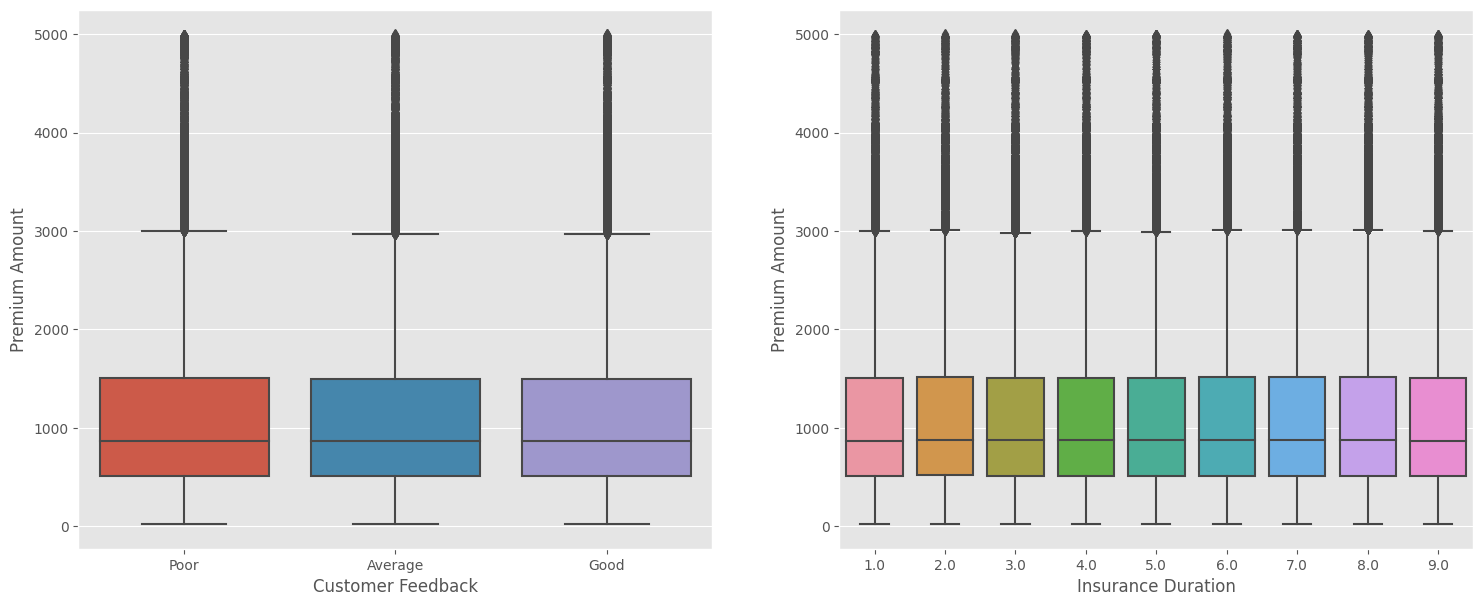

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

plt_1 = sns.boxplot(data=train, x='Customer Feedback', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Insurance Duration', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

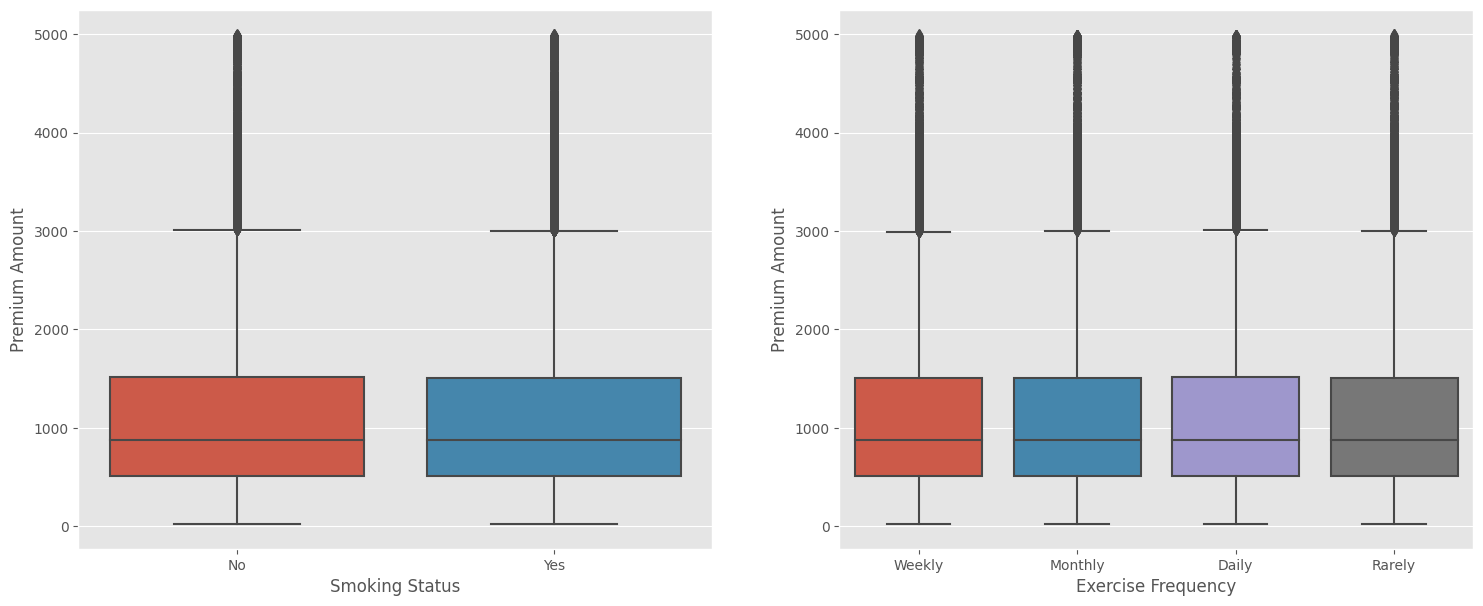

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

plt_1 = sns.boxplot(data=train, x='Smoking Status', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Exercise Frequency', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. 

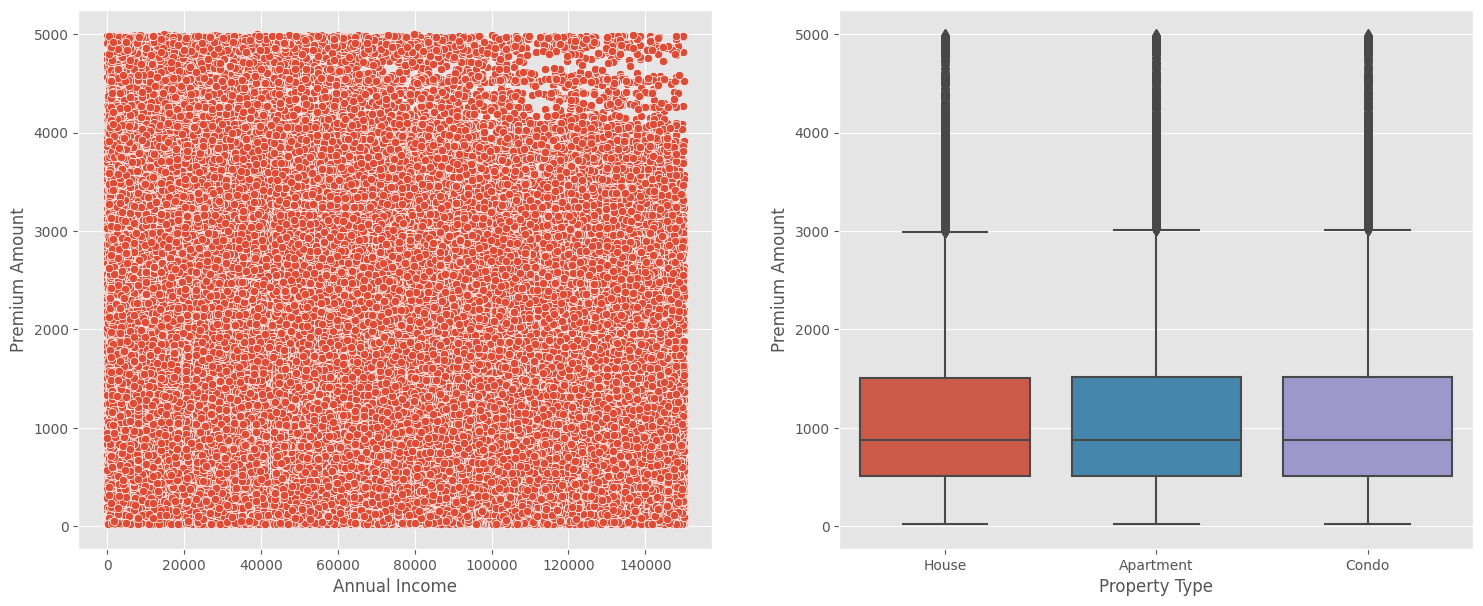

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

plt_1 = sns.scatterplot(data=train, x='Annual Income', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=train, x='Property Type', y='Premium Amount', ax=ax[1]);

From the above charts, there is no interesting relationship that can be exploited for modeling purposes. Based on the different considered chart, the data seems pretty random. 

# Baseline Modeling 1.0

We first preprocess the data as follows.

In [18]:
%%time 
def feature_processing(df):

    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    df['Smoking Status'] = df['Smoking Status'].map({'No': 0, 'Yes': 1})
    df['Previous Claims'] = df['Previous Claims'].clip(None, 8)    

    return df

train = feature_processing(train)
test = feature_processing(test)

cat_cols = ['Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Exercise Frequency',
 'Property Type']

for col in cat_cols:
    train[col] = train[col].astype('str')
    test[col] = test[col].astype('str')

CPU times: user 495 ms, sys: 57 ms, total: 552 ms
Wall time: 551 ms


Then, we define the input and target features for modeling purposes.

In [19]:
%%time 
X = train.drop(columns=['Policy Start Date', 'Premium Amount'], axis=1)
y = train['Premium Amount']

test_cv = test.drop(columns=['Policy Start Date'], axis=1)

skf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2)

CPU times: user 135 ms, sys: 102 ms, total: 237 ms
Wall time: 236 ms


In [20]:
%%time
cb_params = {'loss_function': 'MAE',
             'iterations': 500,
             'task_type': 'GPU'}

test_pool = Pool(data=test_cv, cat_features=cat_cols)

scores, cat_test_preds = [], []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostRegressor(**cb_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict(eval_pool)
    
    score = mean_squared_log_error(y_test, preds)
    print(f"The oof RMSLE score is {score}")
    scores.append(score)
    
    cat_test_preds.append(cat_md.predict(test_pool))

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof RMSLE score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof RMSLE score of the CatBoost model is {cat_std}")

------------ Working on Fold 0 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2332393271703577
------------ Working on Fold 1 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2328442136226043
------------ Working on Fold 2 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2369638699761607
------------ Working on Fold 3 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2244619021853378
------------ Working on Fold 4 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2305954352098185
------------ Working on Fold 5 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2254139177987309
------------ Working on Fold 6 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.229344849385248
------------ Working on Fold 7 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2353229048203835
------------ Working on Fold 8 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2224549530050666
------------ Working on Fold 9 ------------


Default metric period is 5 because MAE is/are not implemented for GPU


The oof RMSLE score is 1.2469767674618255
The 10-fold average oof RMSLE score of the CatBoost model is 1.2317618140635533
The 10-fold std oof RMSLE score of the CatBoost model is 0.006797032550027502
CPU times: user 8min 17s, sys: 16.6 s, total: 8min 33s
Wall time: 7min 14s


In [21]:
%%time
submission = pd.read_csv('../input/playground-series-s4e12/sample_submission.csv')
submission['Premium Amount'] = np.mean(cat_test_preds, axis=0)
submission.head()

CPU times: user 523 ms, sys: 13.8 ms, total: 537 ms
Wall time: 321 ms


,id,Premium Amount
0,1200000,872.121653
1,1200001,872.196964
2,1200002,872.038997
3,1200003,872.038997
4,1200004,872.038997


In [22]:
submission.to_csv('baseline_sub_1.csv', index=False)